# ResNet18 Image Tile Feature Extraction

This notebook processes geospatial Image Tiles for each DHS cluster through ResNet18, extracts features from convolutional layers, and projects them using UMAP. The UMAP projections are then processed through a clustering algorithm to identify and quantify the clusters. The original DHS points are stored in a GeoJSON file along with the color-coded cluster assignments, which allows them to be plotted in QGIS to visualize the clusters in a geospatial context.

## File System Structure

## Input

The input GeoTiff files for each data type (for each DHS location) are loacted in `Image_Tiles` within the hierarchy below. 

<pre style="font-family: monospace;">
./GIS-Image-Stack-Processing
    /AOI/
        PK/
            Image_Tiles/
                Nightlights/
                   # Cropped image tiles at each DHS cluster location.
                    PK_42N_001_C-002_Nightlights_2022_400m.tif
                    PK_42N_002_C-003_Nightlights_2022_400m.tif
                    :
                    PK_42N_265_C-415_Nightlights_2022_400m.tif
                
                Population/
                    PK_42N_001_C-002_Population_2022_400m.tif
                    :
                
                Rainfall/
                    PK_42N_001_C-002_Rainfall_2023_400m
                    :
</pre>

## Output

<pre style="font-family: monospace;">
./ResNet_Features_GeoJSON/
    ResNet18_Features_layer4_clusters_map_PK_3clusters.geojson

./ResNet_Features_Plots/
    PK-layer4-RNP-spectral-30-0.01.png
    PK-layer4-RNP-spectral-30-0.01-3clusters.png
</pre>


## Required Configurations

The following configurations are required for each execution of this notebook: the two-letter country code and the layer number to extract features from ResNet18 (e.g., `layer3`, `layer4`).

<pre style="font-family: monospace;">
<span style="color: blue;">country_code  = 'PK'</span>      # Set the country code
<span style="color: blue;">feature_layer = 'layer4'</span>  # ResNet18 layer to extract features from
</pre>

In [157]:
#-------------------------------------------------
# REQUIRED CONFIGURATIONS HERE
#-------------------------------------------------
country_code  = 'TD'      # Set the country code
feature_layer = 'layer4'  # ResNet18 layer to extract features from
#-------------------------------------------------

In [158]:
import os
import sys
import re
import rasterio
import numpy as np
import math
import random
import glob

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights
from torchinfo import summary

import pandas as pd
import geopandas as gpd
import umap

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN

from dataclasses import dataclass

import matplotlib.pyplot as plt
features_list = [] 

In [159]:
sys.path.append('./GIS-Image-Stack-Processing')  # Adjust path if `gist_utils` is moved
from gist_utils import aoi_configurations

## System Configuration

In [160]:
def system_config(SEED_VALUE=42, package_list=None):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. 
        package_list (str): String containing a list of additional packages to install  
        for Google Colab or Kaggle. 

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ
        
    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #--------------------------------
    # Check for availability of GPUs. 
    #--------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')

        # This section for installing packages required by Colab.
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
        
        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = True # Insures deterministic even when above cudnn is enabled.
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print('Using Apple Silicon GPU')

        # Set the device to the Apple Silicon GPU Metal Performance Shader (MPS).
        DEVICE = torch.device("mps")
        print("Device: ", DEVICE)
        # Environment variable that allows PyTorch to fall back to CPU execution 
        # when encountering operations that are not currently supported by MPS.
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        GPU_AVAILABLE = True
        
        torch.mps.manual_seed(SEED_VALUE)
        torch.use_deterministic_algorithms(True)
        
    else:
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False
        
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
            print('Note: Change runtime type to GPU for better performance.')
        
        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [161]:
# Additional packages required for Google Colab or Kaggle.
package_list = "torchmetrics torchinfo"

DEVICE, GPU_AVAILABLE = system_config(package_list=package_list)

Using Apple Silicon GPU
Device:  mps


##  ResNet18 Model Definition
The function below defines the ResNet18 model loaded with pretrained ImageNet weights. In feature extraction model, a hook function is defined that will extract features at the output of the specified layer.

In [162]:
def get_resnet_18(output_features=1, feature_extraction=False, feature_layer='layer3'):
    
    global features_list  

    # Instantial the model with ImageNet weights
    model_res_18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    # Create a dictionary mapping layer names to model layers
    layers = {
        'layer1': model_res_18.layer1,
        'layer2': model_res_18.layer2,
        'layer3': model_res_18.layer3,
        'layer4': model_res_18.layer4
    }

    if feature_extraction:
        
        # Disable gradient computations
        for param in model_res_18.parameters():
            param.requires_grad = False

        # Hook function for feature extraction
        def hook_conv(module, input, output):
            
            global features_list
            if not module.training:
                # Extract the features from the layer and detach from the graph
                features_list.append(output.detach())

        # Attach the hook to the specified layer using the dictionary
        layers[feature_layer].register_forward_hook(hook_conv)

        # Set the model's output to the Identity to avoid unecesary computation
        model_res_18.fc = nn.Identity()

    else:
        model_fc_in_features = model_res_18.fc.in_features
        model_res_18.fc = nn.Linear(in_features=model_fc_in_features, out_features=output_features)

    return model_res_18


## Dataset Preparation

In [163]:
@dataclass(frozen=True)
class DatasetConfig:
    COUNTRY_CODE:  str  
    FEATURE_LAYER: str
    IMG_HEIGHT:    int = 224
    IMG_WIDTH:     int = 224
    BATCH_SIZE:    int = 32
    NUM_WORKERS:   int = 0
    DATA_ROOT:     str = './GIS-Image-Stack-Processing/AOI/{country_code}/Image_Tiles/'

    def get_root_dir(self):
        # Resolve wildcard directory path
        pattern = self.DATA_ROOT.format(country_code=self.COUNTRY_CODE)
        resolved_paths = glob.glob(pattern)
        return resolved_paths
    
@dataclass(frozen=True)
class ResultsConfig:
    COUNTRY_CODE:  str
    FEATURE_LAYER: str
    GEO_JSON:      str = './ResNet18_Features_GeoJSON/ResNet18_Features_{feature_layer}_clusters_map_{country_code}.geojson'
    OUT_DIR:       str = './ResNet18_Features_Plots'
    
    def get_geojson_filename(self):
        return self.GEO_JSON.format(country_code=self.COUNTRY_CODE, feature_layer=self.FEATURE_LAYER)
    

In [164]:
# Instantiate dataset and result objects
dataset_config = DatasetConfig(COUNTRY_CODE=country_code, FEATURE_LAYER=feature_layer)
results_config = ResultsConfig(COUNTRY_CODE=country_code, FEATURE_LAYER=feature_layer)

# Confirm root dir
dataset_config.get_root_dir()

['./GIS-Image-Stack-Processing/AOI/TD/Image_Tiles/']

## DHS Survey Locations

Specify the DHS shape file path that contains the DHS survey locations. The cluster IDs and (lat,lon) for each survey location will be used

In [165]:
# Set path names

base_path = './GIS-Image-Stack-Processing'

shapefile_path = os.path.join(base_path, aoi_configurations[country_code]['shapefile'])

cluster_field  = 'DHSCLUST'
lat_field      = 'LATNUM'
lon_field      = 'LONGNUM'

## Set Output Paths

In [166]:
geojson_file = results_config.get_geojson_filename()

directory = os.path.dirname(geojson_file)
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory created: {directory}")
    

## Custom Dataset Class for Loading and Pre-Processing Geospatial Data

In [167]:
#ORIGINAL
# class MultiChannelGeoTiffDataset(Dataset):
    
#     def __init__(self, root_dirs, channels, data_types, transform=None):
        
#         self.root_dirs = root_dirs  # This is now a list of directories
#         self.channels = channels
#         self.data_types = data_types
#         self.transform = transform
#         self.file_list, self.cluster_ids = self._build_file_list()

#     def _build_file_list(self):
        
#         directory_files = {}
#         # Walk through each root directory to gather files
#         for root_dir in self.root_dirs:
#             for subdir, dirs, files in os.walk(root_dir):
#                 for file in files:
#                     # Check if the file belongs to one of the required data types
#                     for dt in self.data_types:
#                         if dt in subdir:
#                             directory_files.setdefault(dt, []).append(os.path.join(subdir, file))

#         # Sort files to ensure alignment across types
#         for key in directory_files:
#             directory_files[key].sort()

#         file_list = []
#         cluster_ids = []
        
#         # Assuming equal number of files per type, which must be verified
#         num_samples = len(directory_files[self.data_types[0]])
#         for idx in range(num_samples):
#             files_for_sample = []
#             current_cluster_id = None
#             for dt in self.data_types:
#                 filepath = directory_files[dt][idx]
#                 files_for_sample.append(filepath)

#                 # Extract and verify cluster ID consistency
#                 match = re.search(r"C-(\d+)", filepath)
#                 if match:
#                     cluster_id = int(match.group(1))
#                     if current_cluster_id is None:
#                         current_cluster_id = cluster_id
#                     elif current_cluster_id != cluster_id:
#                         raise ValueError("Mismatched cluster IDs in sample files.")

#             file_list.append(tuple(files_for_sample))
#             cluster_ids.append(current_cluster_id)

#         return file_list, cluster_ids

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         sample_files = self.file_list[idx]
#         cluster_id = self.cluster_ids[idx]

#         channels_data = []
#         for file_path in sample_files:
#             with rasterio.open(file_path) as src:
#                 data = src.read(1, out_dtype="float32")
                
#                 # Normalize each data type to [0, 1]
#                 data = (data - data.min()) / (data.max() - data.min())
#                 channels_data.append(data)
        
#         image = np.stack(channels_data)
#         if self.transform:
#             image = self.transform(image)

#         return image, cluster_id
    
# def geo_transforms(image):
    
#     # Convert to tensor and normalize
#     image = torch.from_numpy(image)
    
#     # Normalize the data samples based on the ImageNet mean and std deviation for each channel
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     image = normalize(image)
    
#     return image

In [168]:
class MultiChannelGeoTiffDataset(Dataset):
    
    def __init__(self, root_dirs, channels, data_types, transform=None):
        self.root_dirs = root_dirs
        self.channels = channels
        self.data_types = data_types
        self.transform = transform
        self.file_list, self.cluster_ids = self._build_file_list()

    def _build_file_list(self):
        directory_files = {}
        unique_data_types = set(self.data_types)  # Use a set to handle unique data types

        # Walk through each root directory to gather files
        for root_dir in self.root_dirs:
            for subdir, dirs, files in os.walk(root_dir):
                for file in files:
                    for dt in unique_data_types:  # Only count files for each unique data type once
                        if dt in subdir:
                            directory_files.setdefault(dt, []).append(os.path.join(subdir, file))

        # Sort files for consistency
        for key in directory_files:
            directory_files[key].sort()

        # Ensure all data types have the same number of files
        expected_num_files = len(directory_files[next(iter(unique_data_types))])  # Get count from any one type
        for dt in unique_data_types:
            if len(directory_files[dt]) != expected_num_files:
                raise ValueError(f"Data type {dt} has mismatched number of files: expected {expected_num_files}, got {len(directory_files[dt])}")

        # Organize files per channel, respecting duplicate data types
        file_list = []
        cluster_ids = []
        for idx in range(expected_num_files):
            files_for_sample = []
            current_cluster_id = None
            for dt in self.data_types:  # Here we use the original list to match the channel configuration
                filepath = directory_files[dt][idx]
                files_for_sample.append(filepath)

                # Extract and verify cluster ID consistency
                match = re.search(r"C-(\d+)", filepath)
                if match:
                    cluster_id = int(match.group(1))
                    if current_cluster_id is None:
                        current_cluster_id = cluster_id
                    elif current_cluster_id != cluster_id:
                        raise ValueError(f"Mismatched cluster IDs in sample files at index {idx} for data type {dt}.")

            file_list.append(tuple(files_for_sample))
            cluster_ids.append(current_cluster_id)

        return file_list, cluster_ids

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        sample_files = self.file_list[idx]
        cluster_id = self.cluster_ids[idx]

        channels_data = []
        for file_path in sample_files:
            with rasterio.open(file_path) as src:
                data = src.read(1, out_dtype="float32")
                data = (data - data.min()) / (data.max() - data.min())
                channels_data.append(data)
        
        image = np.stack(channels_data)
        if self.transform:
            image = self.transform(image)

        return image, cluster_id


## Create `data_loader`

In [169]:
# Need to experiment with differnet channel orders

#data_types = ['Nightlights', 'Population', 'Rainfall']
#data_types = ['Nightlights', 'Rainfall',    'Population']

#data_types = ['Population',  'Nightlights', 'Rainfall']
#data_types = ['Population',  'Rainfall',    'Nightlights']

#data_types = ['Rainfall',    'Population',  'Nightlights']
data_types = ['Rainfall',    'Nightlights', 'Population']

transform = transforms.Compose([geo_transforms])
train_dataset = MultiChannelGeoTiffDataset(root_dirs=dataset_config.get_root_dir(),
                                           channels=[0, 1, 2],
                                           data_types=data_types,
                                           transform=transform)

data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Model Instantiation

In [170]:
model = get_resnet_18(feature_extraction=True, feature_layer=dataset_config.FEATURE_LAYER)

print(summary(model,
              input_size=(1, 3, dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
              row_settings=["var_names"])) 

model = model.float().to(DEVICE)

Layer (type (var_name))                  Output Shape              Param #
ResNet (ResNet)                          [1, 512]                  --
├─Conv2d (conv1)                         [1, 64, 112, 112]         (9,408)
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         (128)
├─ReLU (relu)                            [1, 64, 112, 112]         --
├─MaxPool2d (maxpool)                    [1, 64, 56, 56]           --
├─Sequential (layer1)                    [1, 64, 56, 56]           --
│    └─BasicBlock (0)                    [1, 64, 56, 56]           --
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]           (128)
│    │    └─ReLU (relu)                  [1, 64, 56, 56]           --
│    │    └─Conv2d (conv2)               [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d (bn2)            [1, 64, 56, 56]           (128)
│    │    └─ReLU (relu)                  [1, 64, 56, 56]   

## Feature Extraction

In [171]:
def extract_features(model, data_loader, device='cpu'):
    
    model.to(device)
    model.eval()
    global features_list
    features_list = []
    cluster_ids = []

    with torch.no_grad():
        for images, ids in data_loader:
            images = images.to(device)
            _ = model(images)
            cluster_ids.extend(ids)  # Collect cluster IDs

    all_features = torch.cat([torch.flatten(features, start_dim=1) for features in features_list], dim=0).numpy()

    return all_features, cluster_ids

In [172]:
def plot_umap(features, cluster_ids, annotate_points=False, font_size=8, use_distinct_colors=False, n_clusters=None, umap_case=None, out_dir=None):
    
    distinct_colors = [
        'red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan',
        'magenta', 'yellow', 'black', 'lime', 'maroon', 'navy', 'teal', 'coral', 'gold', 'indigo',
        'violet', 'salmon', 'beige', 'azure', 'lavender', 'khaki', 'crimson', 'turquoise', 'chocolate', 'orchid']
        
    init = 'random'
    init = 'spectral'
    n_neighbors = 30
    min_dist = 0.01
    
    umap_case = umap_case + '-' + init + '-' + str(n_neighbors) + '-' + str(min_dist)
    if use_distinct_colors:
        
        if n_clusters is not None:
            # Add the specific number of clusters if provided
            umap_case = umap_case + '-' + str(n_clusters) + 'clusters'
        else:
            # Add "clusters" to case name
            umap_case = umap_case + '-clusters'

    # Create the UMAP reduce
    #umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42, init=init)
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42, init=init)
    umap_features = umap_reducer.fit_transform(features)

    plt.figure(figsize=(12, 10))
    
    # Choose color map or distinct colors based on the flag
    if use_distinct_colors and len(set(cluster_ids)) <= len(distinct_colors):
        color_sequence = [distinct_colors[i] for i in cluster_ids]
        scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], c=color_sequence, s=50, alpha=0.4)
    else:
        scatter = plt.scatter(umap_features[:, 0], umap_features[:, 1], c=cluster_ids, s=50, cmap='Spectral', alpha=0.4)
#         plt.colorbar(scatter, label='Cluster ID')
    
    plt.title(f'{umap_case}', fontsize=16)

    if annotate_points:
        for i, txt in enumerate(cluster_ids):
            if isinstance(txt, torch.Tensor):
                txt = txt.item()  # Converts a single-value tensor to a Python number
            plt.annotate(str(txt), (umap_features[i, 0], umap_features[i, 1]),
                         textcoords="offset points", xytext=(0,10), ha='center', fontsize=font_size, color='gray')
        
    if out_dir and umap_case:
        plot_file = os.path.join(out_dir, f"{umap_case}.png")
        plt.savefig(plot_file, format='png')
        print(plot_file)
        
    plt.show()

In [173]:
umap_features, umap_cluster_ids = extract_features(model, data_loader, device='cpu')

/Users/billk/miniforge3/envs/py39-pt/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


./ResNet18_Features_Plots/TD-layer4-RNP-spectral-30-0.01.png


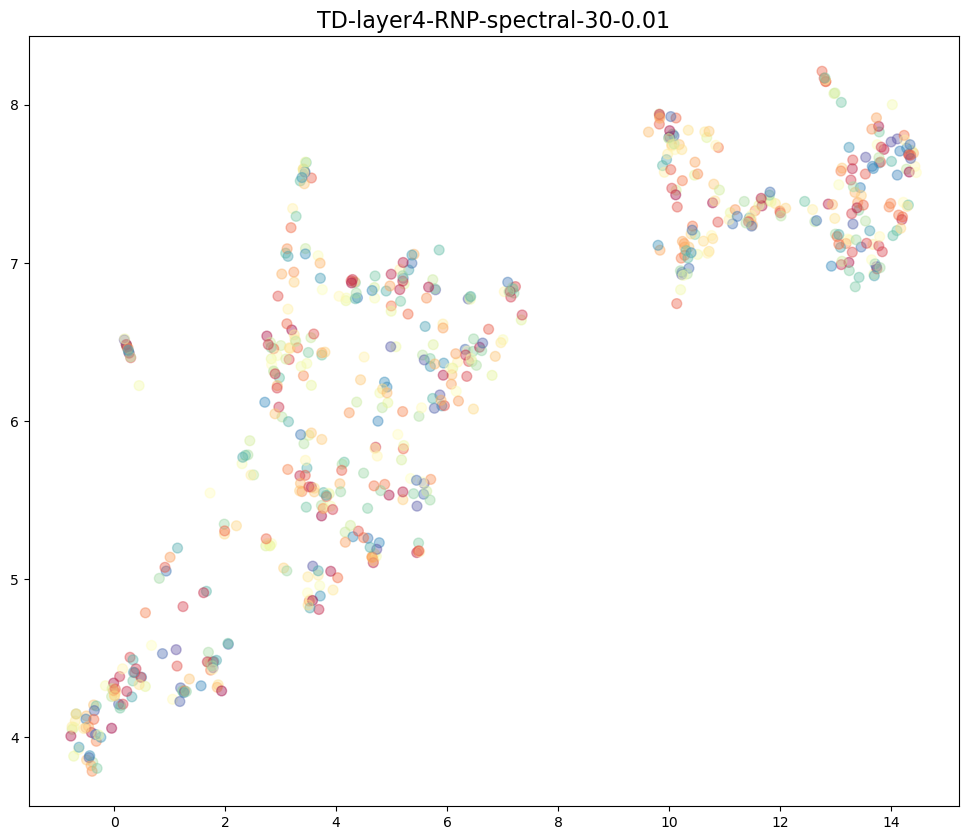

In [174]:
umap_case = country_code + '-' + feature_layer + '-' + ''.join([data_type[0] for data_type in data_types])

plot_umap(umap_features, umap_cluster_ids, umap_case=umap_case, out_dir=results_config.OUT_DIR)

In [117]:
print(f"all_features shape: {umap_features.shape}") 

all_features shape: (970, 25088)


In [175]:
# Convert tensor UMAP cluster IDs to strings matching the shapefile format
umap_cluster_ids = [str(int(cid.item())) + '.0' for cid in umap_cluster_ids]

## Apply Spectral Clustering

In [176]:
# Specify the number of clusters
n_clusters = 3

# Initialize and fit Spectral Clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                              assign_labels='kmeans', random_state=42, n_init=10)

cluster_labels = spectral.fit_predict(umap_features)

/Users/billk/miniforge3/envs/py39-pt/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


./ResNet18_Features_Plots/TD-layer4-RNP-spectral-30-0.01-3clusters.png


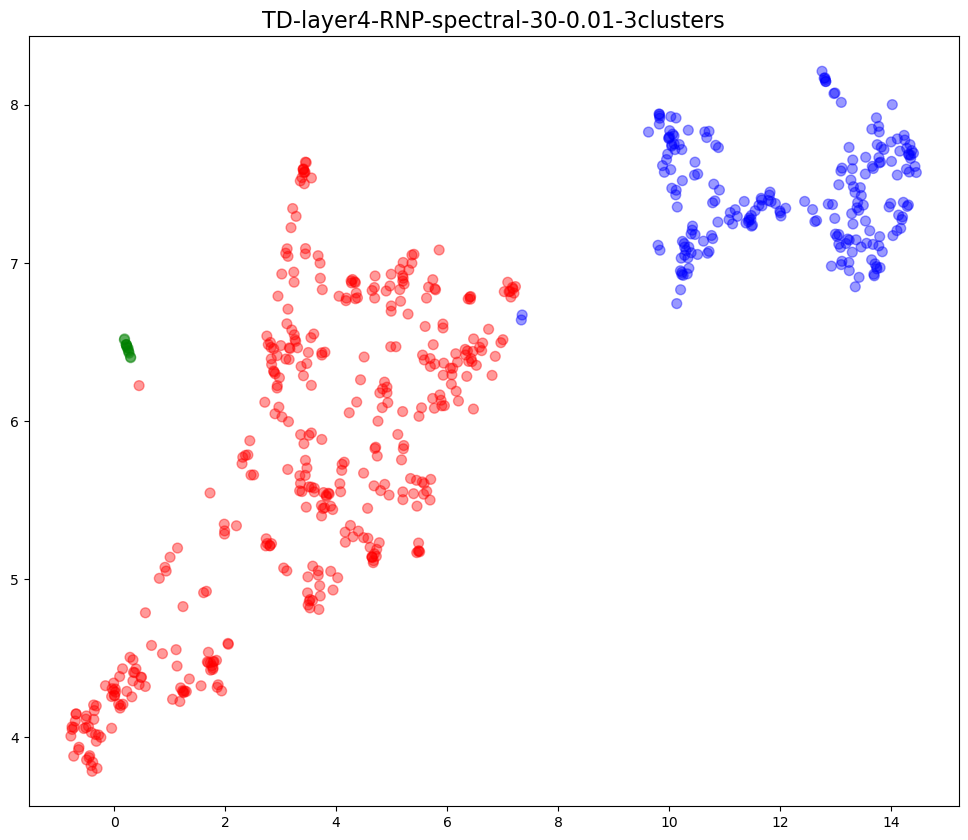

In [177]:
umap_case = country_code + '-' + feature_layer + '-' + ''.join([data_type[0] for data_type in data_types])

plot_umap(umap_features, cluster_labels, use_distinct_colors=True, n_clusters=n_clusters, umap_case=umap_case, out_dir=results_config.OUT_DIR)

In [178]:
# k = 3  # Specify the number of clusters
# kmeans = KMeans(n_clusters=k, random_state=42)
# cluster_labels = kmeans.fit_predict(umap_features)

In [179]:
# plot_umap(umap_features, cluster_labels, use_distinct_colors=True, n_clusters=n_clusters, umap_case=umap_case, out_dir=results_config.OUT_DIR)

## Extract DHS Cluster Data from Shapefile

Retrieve the DHS survey cluster data (ID, Lat, Lon).

In [180]:
def extract_cluster_data(shapefile_path, cluster_field, lat_field, lon_field):

    gdf = gpd.read_file(shapefile_path)
    if cluster_field not in gdf.columns or lat_field not in gdf.columns or lon_field not in gdf.columns:
        raise ValueError("One or more field names do not exist in the shapefile.")
        
    data = gdf[[cluster_field, lat_field, lon_field]]
    cluster_data = [tuple(x) for x in data.to_numpy()]
    
    return cluster_data

In [181]:
cluster_data = extract_cluster_data(shapefile_path, cluster_field, lat_field, lon_field)

In [182]:
# Print a few records
for idx in range(0,5):
    print(cluster_data[idx]) 

(1.0, 9.453506, 18.944837)
(2.0, 13.466001, 22.196232)
(3.0, 15.749017, 18.285138)
(4.0, 12.13549, 15.206105)
(5.0, 9.264128, 16.400491)


In [183]:
cluster_df = pd.DataFrame(cluster_data, columns=['cluster_id', 'latitude', 'longitude'])
cluster_df['cluster_id'] = cluster_df['cluster_id'].astype(str)  # Convert to string

## Create GeoJSON 

Create a GeoJSON file that associates the individual DHS survey data with the clusters labels computed above.

In [184]:
umap_results_df = pd.DataFrame({
    'cluster_id': umap_cluster_ids,    # UMAP cluster IDs now in string format like '101.0'
    'cluster_label': cluster_labels    # Assume this is already correctly aligned with umap_cluster_ids
})

# Filter the cluster DataFrame to only include rows with cluster_ids in umap_cluster_ids
filtered_cluster_df = cluster_df[cluster_df['cluster_id'].isin(umap_cluster_ids)]
if filtered_cluster_df.empty:
    print("No matching cluster IDs found after filtering. Check umap_cluster_ids list.")

# Merge the filtered cluster data with UMAP results based on 'cluster_id'
merged_df = pd.merge(filtered_cluster_df, umap_results_df, on='cluster_id', how='inner')

if merged_df.empty:
    print("Merging resulted in no data. Ensure data types and cluster IDs match exactly.")

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude),
    crs="EPSG:4326"  
)

# Save to GeoJSON (add number of clusters to filename)
base, ext = os.path.splitext(geojson_file)
suffix = '_' + str(n_clusters) + 'clusters'
geojson_file = f"{base}{suffix}{ext}"

gdf.to_file(geojson_file, driver='GeoJSON')

# Output some diagnostics
print("Filtered DataFrame:")
print(filtered_cluster_df.head())
print("Length of Filtered DataFrame:", len(filtered_cluster_df))

print("UMAP Results DataFrame:")
print(umap_results_df.head())
print("Length of UMAP Results DataFrame:", len(umap_results_df))

print("Merged DataFrame:")
print(merged_df.head())
print("Length of Merged DataFrame:", len(merged_df))

Filtered DataFrame:
  cluster_id   latitude  longitude
0        1.0   9.453506  18.944837
1        2.0  13.466001  22.196232
2        3.0  15.749017  18.285138
3        4.0  12.135490  15.206105
4        5.0   9.264128  16.400491
Length of Filtered DataFrame: 624
UMAP Results DataFrame:
  cluster_id  cluster_label
0      419.0              0
1      533.0              1
2      246.0              1
3       61.0              0
4      137.0              1
Length of UMAP Results DataFrame: 624
Merged DataFrame:
  cluster_id   latitude  longitude  cluster_label
0        1.0   9.453506  18.944837              0
1        2.0  13.466001  22.196232              0
2        3.0  15.749017  18.285138              1
3        4.0  12.135490  15.206105              0
4        5.0   9.264128  16.400491              0
Length of Merged DataFrame: 624


In [185]:
print(f"all_features shape: {umap_features.shape}") 

all_features shape: (624, 25088)
